# Assignment 2: Support Vector Machines

In this assignment you will:
* Implement a linear SVM via stochastic gradient descent
* Do multi-class handwritten digit classification with off-the-shelf SVM solvers (with kernel functions)
* Tune model hyper-parameters to achieve good generalisation

# Part 1: Implement a linear SVM

## Setup

First import the required packages and do some setup:

In [34]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from sklearn.model_selection import train_test_split
from assignment2 import svm_loss, svm_gradient, svm_solver

# Set default parameters for plots
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now load the face dataset. The labels are set to **-1 for non-face and 1 for face**.

In [35]:
# Load the dataset
data = loadmat('faces.mat')
labels = np.squeeze(data['Labels'])
data = data['Data']

Divide the dataset into train and test sets.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (13882, 576)
Training labels shape:  (13882,)
Test data shape:  (5950, 576)
Test labels shape:  (5950,)


Visualize some examples to check that the data is fine:

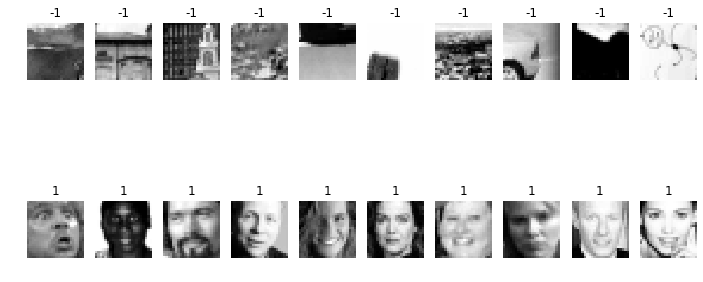

In [37]:
# Visualize some examples from the dataset.
samples_per_class = 10
classes = [-1, 1]
train_imgs = np.reshape(X_train, [-1, 24, 24], order='F')

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(np.equal(y_train, cls))
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = y * samples_per_class + i + 1
        plt.subplot(len(classes), samples_per_class, plt_idx)
        plt.imshow(train_imgs[idx])
        plt.axis('off')
        plt.title(cls)
plt.show()

## Exercise 1: The SVM loss function [15 Points]

Recall the formulation of the SVM optimization problem as follows:

\begin{aligned}
& \min_{w, b}
& & \frac{1}{2}||w||^2 + C\sum_{i=1}^m \xi_i \\
& \ \text{ s.t.}
& & y^{(i)}(w^Tx^{(i)}+b) \geq 1-\xi_i, \; i = 1, \ldots, m \\
& & & \xi_i \geq 0, \; i = 1, \ldots, m \\
\end{aligned}

Let $f(x)=w^Tx+b$. The constraints can then be written as $y^{(i)}f(x^{(i)})\geq 1-\xi_i$. Together with the constraints $\xi_i \geq 0$ this leads to $\xi_i=\max(0, 1-y^{(i)}f(x^{(i)}))$. The above constraint optimization problem is therefore equivalent to the following **unconstraint** problem:

\begin{equation}
\min_{w, b} \frac{\lambda}{2}||w||^2 + \frac{1}{m}\sum_{i=1}^m \max(0, 1-y^{(i)}f(x^{(i)}))
\end{equation}

The first term in this objective is a regularization term (prevents overfitting) and the second term measures the classification loss. Here the parameter $\lambda=1/C$ is a **hyper-parameter** that controls the relative weight of  both losses.


**TODO**: Implement the **unconstrained** objective function for SVM in *svm_loss.py* according to the specifications.

***HINT***: Consider again what you would expect with the provided values of w, b and C.

In [38]:
# Test your cost-function
w_0 = np.zeros(X_train.shape[1])
b_0 = 0.
l_0 = svm_loss(w_0, b_0, X_train, y_train, 1.)
print('SVM-loss with initial parameters: ', l_0)

SVM-loss with initial parameters:  1.0


## Exercise 2: The SVM Gradient [15 Points]

**TODO**: Implement the gradient of the above unconstrained objective w.r.t. to the parameters $w$ and $b$. The gradient will be computed on a mini-batch (i.e., a random subset of the training set).

**Hint**: Don't worry about the fact that $\max(0, 1-y^{(i)}f(x^{(i)}))$ is not differentiable at $1-y^{(i)}f(x^{(i)})=0$. Just pick a one-sided gradient (this is called a subgradient for convex functions).

In [43]:
# Test your implementation
x_ = np.ones([2, 10])
y_ = np.array([1, -1])
w_0 = np.zeros(10)
b_0 = 0.
print(y_[1]*x_[1,:])
grad_w, grad_b = svm_gradient(w_0, b_0, x_, y_, 1.)
print(grad_w)
print(grad_b)



TypeError: 'int' object is not subscriptable

## Exercise 3: The SVM Solver [20 Points]

You will implement the **Pegasos** algorithm - a variant of SGD - to solve for the parameters $w$ and $b$. 

The algorithm was introduced in the following [Paper](http://ttic.uchicago.edu/~nati/Publications/PegasosMPB.pdf) (see Figure 2). It is essentially Stochastic Gradient Descent on mini-batches + a specific choice for the learning rate giving convergence guarantees. The required steps are outlined in **svm_solver.py**. For more details, please refer to the [Paper](http://ttic.uchicago.edu/~nati/Publications/PegasosMPB.pdf).

**TODO**: Implement the Pegasos algorithm in **svm_solver.py** according to specs. 

***HINT***: You know what performance to expect from the previous assignment (maybe you need to tune the hyper-parameter **C**)

In [ ]:
# We'll meausure the execution time
start = time.time()

C = 3.0
w, b = svm_solver(X_train, y_train, C, num_iter=30000, num_per_batch=64)

exec_time = time.time()-start
print('Total exection time: {}s'.format(exec_time))

# We can have a look at what theta has learned to recognise as "face"
plt.imshow(np.reshape(w, [24, 24], order='F'))
plt.title('Learned w')
plt.show()

# Make predictions
preds_train = np.ones_like(y_train) - 2 * (np.dot(X_train, w) + b < 0)
preds_test = np.ones_like(y_test) - 2 * (np.dot(X_test, w) + b < 0)

print('Accuracy train: {}'.format(np.mean(preds_train == y_train)))
print('Accuracy test: {}'.format(np.mean(preds_test == y_test)))

# Part 2: Multi-Class SVM

In this second part of the assignment you will train a multi-class SVM on a dataset of handwritten digits.

A seperate (withheld) test set will be used for the evaluation of your classifiers. It is therefore important that you take good care not to overfit and ensure that your models generalize to unseen data.


## Setup

First load and visualize some of the data:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

classes = range(10)

data = np.load('data.npy', encoding='latin1')
X = data[()]['X']
y = data[()]['y']

# Visualize some examples from the dataset.
samples_per_class = 5
imgs = np.reshape(X, [-1, 16, 16])
labels = y

for j, cls in enumerate(classes):
    idxs = np.flatnonzero(np.equal(labels, cls))
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = j * samples_per_class + i + 1
        plt.subplot(samples_per_class, len(classes), plt_idx)
        plt.imshow(imgs[idx])
        plt.axis('off')
        plt.title(cls)
plt.show()

## Exercise 4: Preparing the data [10 Points]

In this exercise you should:
* Prepare the data for cross validation (train/test splits)
* Preprocess the data for use with the SVM (this can have a **big** effect on the performance!)

**NOTE:** You are allowed to use any functions in sklearn for this exercise

In [ ]:
from sklearn import preprocessing

X_train = y_train = X_test = y_test = None

#######################################################################
# TODO:                                                               #
# Arrange the data into train and test sets                           #
# Be careful about how you split the data:                            #
# - If train and test distribution are very different your test       #
#   performance will be poor                                          #
# - Think about the sizes of the splits: What are good values and how #
#   does this affect your train/test performance?                     #
#######################################################################

pass

#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################


def pre_process(x):
    #######################################################################
    # TODO:                                                               #
    # Implement preprocessing of the data before feeding to the SVM.      #
    # NOTE: This function will be used to grade the performance on the    #
    # held-out test set                                                   #
    #######################################################################
    
    pass
    
    #######################################################################
    #                         END OF YOUR CODE                            #
    #######################################################################
    return x

X_train = pre_process(X_train)
X_test = pre_process(X_test)

print('Training data shape:', X_train.shape)
print('Training labels shape:', y_train.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

## Exercise 5: Training and evaluating a linear SMV [10 Points]

Now its time to train a linear SVM on your training data and evaluate its performance on the test set.

You should use [sklearn.svm.LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) for training the model. See the documentation for usage, arguments, return values and methods.

In [ ]:
from sklearn.svm import LinearSVC

def train_linear_SVM(X, y, C, max_iter=100):
    """
    Linear multi-class SVM solver.

    Args:
        X: Data matrix of shape [num_train, num_features]
        y: Labels corresponding to X of size [num_train]
        C: Hyper-parameter for SVM
        max_iter: Maximum number of iterations

    Returns:
        lin_clf: The learnt classifier (LinearSVC instance)

    """
    lin_clf = None
    print('Solving linear-SVM...')

    #######################################################################
    # TODO:                                                               #
    # Train the SVM using LinearSVC and return the learnt classifier      #
    #######################################################################

    pass

    #######################################################################
    #                         END OF YOUR CODE                            #
    #######################################################################
    return lin_clf

C = 5.0
lin_clf = train_linear_SVM(X_train, y_train, C)

#######################################################################
# TODO:                                                               #
# Visualize the learnt weights (lin_clf.coef_) for all the classes:   #
# - Make a plot with ten figures showing the respective weights for   #
#   each of the classes                                               #
#######################################################################

pass

#######################################################################
#                         END OF YOUR CODE                            #
#######################################################################


## Exercise 7: Evaluating a multi-class classifier [10 Points]

You should now evaluate you learnt classifier. For this you have to:
* Compute predictions on the train and test sets
* Compute the accuracy of the predictions
* Compute the confusion matrix (see [here](https://en.wikipedia.org/wiki/Confusion_matrix) for info)
* Answer the question below

**Note:** You can make use of sklearn.metrics


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

def eval_clf(y_pred_train, y_train, y_pred_test, y_test):
    #######################################################################
    # TODO:                                                               #
    # Use the learnt classifier to make predictions on the test set.      #
    # Compute the accuracy on train and test sets.                        #
    # Compute the confusion matrix on the test set.                       #
    #######################################################################

    acc_test = acc_train = cm_test = None

    #######################################################################
    #                         END OF YOUR CODE                            #
    #######################################################################
    return acc_train, acc_test, cm_test

acc_train, acc_test, cm_test = eval_clf(
    lin_clf.predict(X_train),
    y_train,
    lin_clf.predict(X_test),
    y_test)
print("Linear SVM accuracy train: {}".format(acc_train))
print("Linear SVM accuracy test: {}".format(acc_test))
print("Confusion matrix:\n%s" % cm_test)

## Question: 
* Which pair of digits does the classifier confuse most often?

***Your Answer:***

After comparing some confusion matrices the highest numbers were usually within the rows of 3, 8 and 9 and most notably the pair of 4 and 9 got confused the most often.

## Exercise 7: Training and evaluating a SMV with Gaussian kernel [10 Points]

Now you will train a SVM with Gaussian kernel (also called RBF kernel).

You should use [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for training the model. See the documentation for usage, arguments and return values.
Experiment with values for the hyper-parameters $C$ and $\gamma$ and answer the question below.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


def train_gaussian_SVM(X, y, C, gamma, max_iter=100):
    """
    Multi-class SVM solver with Gaussian kernel.

    Args:
        X: Data matrix of shape [num_train, num_features]
        y: Labels corresponding to X of size [num_train]
        C: Hyper-parameter for SVM
        max_iter: Maximum number of iterations

    Returns:
        w: The value of the parameters after logistic regression

    """
    print('Solving RBF-SVM: This can take a while...')
    
    #######################################################################
    # TODO:                                                               #
    # Train the SVM using LinearSVC and return the learnt classifier      #
    #######################################################################

    clf_rbf = None

    #######################################################################
    #                         END OF YOUR CODE                            #
    #######################################################################
    return clf_rbf

C = 100.0
gamma = 10.0
clf_rbf = train_gaussian_SVM(X_train, y_train, C, gamma)

acc_train, acc_test, cm_test = eval_clf(
    clf_rbf.predict(X_train),
    y_train,
    clf_rbf.predict(X_test),
    y_test)
print("RBF SVM accuracy train: {}".format(acc_train))
print("RBF SVM accuracy test: {}".format(acc_test))
print("Confusion matrix:\n%s" % cm_test)

## Exercise 8: Changing data size [5 Points]

Let us also investigate how the amount of the data influence the performance of the model. You will extract a randomly chosen part of the training data with reduced size to train the model on.

In [ ]:
def extract_data_part(X, y, part):    
    #######################################################################
    # TODO:                                                               #
    # Randomly choose part of the data with size part*X.shape[0]          #
    # Return X_part, y_part                                               #
    #######################################################################

    X_part = y_part = None
    
    #######################################################################
    #                         END OF YOUR CODE                            #
    #######################################################################
    
    return X_part, y_part


part = 0.1
X_train_part, y_train_part = extract_data_part(X_train, y_train, part)
X_train_part = pre_process(X_train_part)

C = 100.0
gamma = 10.0
clf_rbf_part = train_gaussian_SVM(X_train_part, y_train_part, C, gamma)

acc_train, acc_test, cm_test = eval_clf(
    clf_rbf_part.predict(X_train_part),
    y_train_part,
    clf_rbf_part.predict(X_test),
    y_test)
print("RBF SVM accuracy train: {}".format(acc_train))
print("RBF SVM accuracy test: {}".format(acc_test))
print("Confusion matrix:\n%s" % cm_test)

The model is apparently overfitted. Seems like the proper regularization could help. Try to tune the hyperparameters $C$ and $\gamma$ to make the performance of the model as close to the one trained on the whole dataset as possible.

Now let's change the data size and plot the accuracy of the model depending on the size of the dataset.

In [ ]:
train_accs = list()
test_accs = list()

part_range = [0.1, 0.3, 0.5, 0.7, 1.0]
for part in part_range:
    print("Training the model for {}% of the train data".format(part * 100))
    #######################################################################
    # TODO:                                                               #
    # Extract the corresponding part of the training data                 #
    # Train the model and evaluate train and test accuracies              #
    #######################################################################

    acc_train = acc_test = None
    
    #######################################################################
    #                         END OF YOUR CODE                            #
    #######################################################################
    
    train_accs.append(acc_train)
    test_accs.append(acc_test)

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Accuracy depending on data size", fontsize=15)
plt.plot(part_range, train_accs, label="train_acc")
plt.plot(part_range, test_accs, label="test_acc")
plt.xticks(part_range, part_range)
plt.legend(fontsize=15)
plt.show()

## Question:
* How do the hyper-parameters influence the classifier? What happens for extreme values of the hyper-parameters?

***Your Answer:***

* What can you say about the influence of the data size on the performance of the model?

***Your Answer:***

## Exercise 9: Questions [10 Points]

Answer the following questions and justify your answers:

* How does your implementation of the linear SVM (Pegasos) compare to the classifiers of the previous assignment? Which method is the most accurate? Which one the fastest to train? Which one is the most versatile?

	***Your Answer:***


* Linear SVM vs. Gaussian Kernel SVM: Give advantages and disadvantages of both approaches. 

	***Your Answer:***


* Linear SVM vs. Gaussian Kernel SVM: In what setting would you pick one method over the other? Answer in terms of number of training examples $m_{train}$ and feature dimension $d$

	***Your Answer:***

## Bonus: Tune those Hyper-Parameters! [10 Points]

Perform hyper-parameter tuning for the two multi-class SVMs. Your performance will be measured on a held-out test set and the **10% best scoring submissions get 5 bonus points** (5 points for linear-SVM and 5 points for RBF-SVM). 

Set the best parameter values above. The performance will be **tested with max_iter=100**!

Additional 5 points can be gained by demonstrating a principled approach for hyper-parameter search below. For ideas refer to:
http://scikit-learn.org/stable/modules/grid_search.html


In [ ]:
# Your optional hyper-parameter tuning code goes here...